# 实验9 残差网络

本实验中你将使用残差网络来构建一个非常深的CNN.
理论上来说, 非常深的网络能够表达非常复杂的函数. 但实际中, 非常深的网络很难训练(由于梯度爆炸/消失等问题).
残差网络(Residual Networks), 由 [He 等人提出](https://arxiv.org/pdf/1512.03385.pdf), 使得训练较深的网络结构成为可能.

**实验目标:**

- 使用Keras来实验一个基础的残差块
- 将残差块组合成模型并训练一个性能优秀的CNN用于图像分类
- 在你自己的网络结构中实现跳跃连接(skip connection)

<a name='1'></a>
## 1 - 包

In [2]:
import tensorflow as tf
import numpy as np
import scipy.misc
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from lib_resnets_utils import *
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
from matplotlib.pyplot import imshow

from lib_test_utils import summary, comparator
import lib_public_tests

%matplotlib inline

<a name='2'></a>
## 2 - 非常深的神经网络存在的问题

在前面的实验中, 你构建了自己的第一个CNN: 先通过Numpy来实现, 后采用TF和Keras的API来实现.

几年来, CNN开始变得越来越深. 从一开始仅有数层的AlexNet发展到拥有数百层的网络.

* 一方面, 越深的网络表达能力通常越强.

* 另一方面, 当层数变多, 往往会出现梯度快速趋向于0的情况, 且越低的层, 其趋近于0的速度越快. 这使得梯度下降优化变得非常慢.

下图展示了随着迭代次数的增加, 不同层的梯度强度的大小.

<img src="images/vanishing_grad_kiank.png" style="width:450px;height:220px;">

别着急! 你将通过引入残差网络来解决该问题

<a name='3'></a>
## 3 - 构建一个残差网络 ResNets

在ResNets中, 一个 "shortcut" 或者 "skip connection" 允许模型跳跃几层:

<img src="images/skip_connection_kiank.png" width=1000>

上图左展示了网络中的"主路径". 上图右在主路径上添加了一个跳跃路径.
将残差块连起来, 你可以得到一个非常深的网络结构.

在残差块中, 网络可以非常方便地学习得到一个恒等函数.
这意味着, 在一个深层网络中, 有些残差块可以以恒等变换的方式存在, 防止网络性能的下级(因为加上残差块以后, 其输入输出没有发生变化).

根据残差块的输入输出尺寸是否一致, 可将其分为identity block(即尺寸相同)和convolutional block(即尺寸不同)两类.

<a name='3-1'></a>
### 3.1 - The identity block

标准的残差块其输入(例如 $a^{[l]}$)和输出(例如 $a^{[l+2]}$)的尺寸是相同的, 称之为identity block.
下图展示了相关流程:

<img src="images/idblock2_kiank.png" width=1000>

图中上方的路径是"shortcut path." 下方则是"main path." 在流程图中, 注意每一层中的 CONV2D 和 ReLU 步骤. 为了加速训练, 添加了一个 BatchNorm 步骤.
别着急, 在Keras中仅需1行代码即可实现BatchNorm!

在下面的练习中, 你将实现一个比上图模型稍有不同的版本. 如下图所示, 你将跳跃3个隐藏层, 而非上图中的2个隐藏层:

<img src="images/idblock3_kiank.png" width=1000>

具体实现分以下几个步骤:

1. 主路径第一部分:
    - 第一个 CONV2D 具有 $F_1$ 个 (1,1) 的滤波器, 步长为 (1,1). Padding 模式为 "valid" (注: 1×1的卷积不需要进行Padding). 使用0作为种子点进行初始化: `kernel_initializer = initializer(seed=0)`.
    - 第一个 BatchNorm 对 'channels' 轴进行归一化.
    - 然后应用 ReLU 激活函数. 没有超参数.
2. 主路径第二部分:
    - 第二个 CONV2D 具有 $F_2$ 个$(f,f)$ 的滤波器, 步长为 (1,1). Padding 模式为 "same". 使用0作为种子点进行初始化: `kernel_initializer = initializer(seed=0)`.
    - 第二个 BatchNorm 对 'channels' 轴进行归一化.
    - 然后应用 ReLU 激活函数. 没有超参数.
3. 主路径第三部分:
    - 第三个 CONV2D 具有 $F_3$ 个 (1,1) 的滤波器, 步长为 (1,1). Padding 模式为 "valid". 使用0作为种子点进行初始化: `kernel_initializer = initializer(seed=0)`.
    - 第三个 BatchNorm 对 'channels' 轴进行归一化.
    - 注意这部分 **没有** 使用 ReLU 激活.
4. 跳跃连接:
    - 对`X_shortcut` 与第三层的输出 `X` 进行相加操作.
    - **提示**: 上述相加操作的语法伪代码是 `Add()([var1,var2])`
    - 然后应用 ReLU 激活函数. 没有超参数.

<a name='ex-1'></a>
#### 练习 1 - identity_block

实现identity block类型的残差网络. 上述主路径第一部分代码已经给出! 请仔细阅读并理解, 然后实现其余部分.
注意, 上次实验中介绍了TF的Functional API, 此处需要借助这类API来创建跳跃连接.

In [4]:
"""
Function:
    Implementation of the identity block as defined in Figure 4
Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
"""
def identity_block(X, f, filters, training=True, initializer=random_uniform):
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)
    ### START CODE HERE
    ## Second component of main path (≈3 lines)
    # X = None
    # X = None
    # X = None
    X = Conv2D(filters = F2, kernel_size = f,strides = (1, 1),padding='same',kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)
    ## Third component of main path (≈2 lines)
    # X = None
    # X = None
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    ## Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    # X = None
    # X = None
    X = Add()([X_shortcut,X])
    X = Activation('relu')(X)
    ### END CODE HERE

    return X

In [5]:
np.random.seed(1)
X1 = np.ones((1, 4, 4, 3)) * -1
X2 = np.ones((1, 4, 4, 3)) * 1
X3 = np.ones((1, 4, 4, 3)) * 3

X = np.concatenate((X1, X2, X3), axis = 0).astype(np.float32)

A3 = identity_block(X, f=2, filters=[4, 4, 3],
                   initializer=lambda seed=0:constant(value=1),
                   training=False)
print('\033[1mWith training=False\033[0m\n')
A3np = A3.numpy()
print(np.around(A3.numpy()[:,(0,-1),:,:].mean(axis = 3), 5))
resume = A3np[:,(0,-1),:,:].mean(axis = 3)
print(resume[1, 1, 0])

print('\n\033[1mWith training=True\033[0m\n')
np.random.seed(1)
A4 = identity_block(X, f=2, filters=[3, 3, 3],
                   initializer=lambda seed=0:constant(value=1),
                   training=True)
print(np.around(A4.numpy()[:,(0,-1),:,:].mean(axis = 3), 5))

lib_public_tests.identity_block_test(identity_block)

With training=False

[[[  0.        0.        0.        0.     ]
  [  0.        0.        0.        0.     ]]

 [[192.7123  192.7123  192.7123   96.85615]
  [ 96.85615  96.85615  96.85615  48.92808]]

 [[578.1369  578.1369  578.1369  290.56845]
  [290.56845 290.56845 290.56845 146.78423]]]
96.85615

With training=True

[[[0.      0.      0.      0.     ]
  [0.      0.      0.      0.     ]]

 [[0.40739 0.40739 0.40739 0.40739]
  [0.40739 0.40739 0.40739 0.40739]]

 [[4.99991 4.99991 4.99991 3.25948]
  [3.25948 3.25948 3.25948 2.40739]]]
All tests passed!


<a name='3-2'></a>
### 3.2 - The convolutional block

第二类残差块称为 "convolutional block". 由于主路径的输入输出尺寸不一致, 因此需要如下图所示, 在跳跃连接处进行一次CONV2D, 以确保两者尺寸一致, 方可以进行相加操作:

<img src="images/convblock_kiank.png" width=1000>

将激活数据尺寸降低一半, 你可以使用步长为2的 1x1 卷积.

实现 convolutional block 的具体步骤如下:

1. 主路径第一部分:
    - 第一个 CONV2D 具有 $F_1$ 个 (1,1) 的滤波器, 步长为 (s,s). Padding 模式为 "valid". 使用0作为种子点进行初始化: `kernel_initializer = initializer(seed=0)`.
    - 第一个 BatchNorm 对 'channels' 轴进行归一化.
    - 然后应用 ReLU 激活函数. 没有超参数.
2. 主路径第二部分:
    - 第二个 CONV2D 具有 $F_2$ 个$(f,f)$ 的滤波器, 步长为 (1,1). Padding 模式为 "same". 使用0作为种子点进行初始化: `kernel_initializer = initializer(seed=0)`.
    - 第二个 BatchNorm 对 'channels' 轴进行归一化.
    - 然后应用 ReLU 激活函数. 没有超参数.
3. 主路径第三部分:
    - 第三个 CONV2D 具有 $F_3$ 个 (1,1) 的滤波器, 步长为 (1,1). Padding 模式为 "valid". 使用0作为种子点进行初始化: `kernel_initializer = initializer(seed=0)`.
    - 第三个 BatchNorm 对 'channels' 轴进行归一化.
    - 注意这部分 **没有** 使用 ReLU 激活.
4. 跳跃路径第一部分:
    - 使用一个 CONV2D 具有 $F_3$ 个 (1,1) 的滤波器, 步长为 (s,s). Padding 模式为 "valid". 使用0作为种子点进行初始化: `kernel_initializer = initializer(seed=0)`.
    - 使用 BatchNorm 对 'channels' 轴进行归一化.
5. 跳跃连接:
    - 将 shortcut 和 main path 值相加.
    - 应用 ReLU 激活函数. 没有超参数.

<a name='ex-2'></a>    
#### 练习 2 - convolutional_block
实现 convolutional block.

In [8]:
"""
Function:
    Implementation of the convolutional block as defined in Figure 4
Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer,
                   also called Xavier uniform initializer.
Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
"""
def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    ### START CODE HERE
    ## Second component of main path (≈3 lines)
    # X = None
    # X = None
    # X = None
    X = Conv2D(filters = F2, kernel_size = f,strides = (1, 1),padding='same',kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    ## Third component of main path (≈2 lines)
    # X = None
    # X = None
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    ##### SHORTCUT PATH ##### (≈2 lines)
    # X_shortcut = None
    # X_shortcut = None
    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training=training)
    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    # X = None
    # X = None
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    ### END CODE HERE
    
    return X

In [9]:
from lib_outputs import convolutional_block_output1, convolutional_block_output2
np.random.seed(1)
#X = np.random.randn(3, 4, 4, 6).astype(np.float32)
X1 = np.ones((1, 4, 4, 3)) * -1
X2 = np.ones((1, 4, 4, 3)) * 1
X3 = np.ones((1, 4, 4, 3)) * 3

X = np.concatenate((X1, X2, X3), axis = 0).astype(np.float32)

A = convolutional_block(X, f = 2, filters = [2, 4, 6], training=False)

assert type(A) == EagerTensor, "Use only tensorflow and keras functions"
assert tuple(tf.shape(A).numpy()) == (3, 2, 2, 6), "Wrong shape."
assert np.allclose(A.numpy(), convolutional_block_output1), "Wrong values when training=False."
print(A[0])

B = convolutional_block(X, f = 2, filters = [2, 4, 6], training=True)
assert np.allclose(B.numpy(), convolutional_block_output2), "Wrong values when training=True."

print('\033[92mAll tests passed!')


tf.Tensor(
[[[0.         0.66683805 0.         0.         0.888539   0.5274254 ]
  [0.         0.65053654 0.         0.         0.8959285  0.49965227]]

 [[0.         0.63120776 0.         0.         0.86362475 0.47643146]
  [0.         0.568832   0.         0.         0.8553412  0.417093  ]]], shape=(2, 2, 6), dtype=float32)
All tests passed!


<a name='4'></a>  
## 4 - 构建你的第一个残差网络模型 (含 50 层)

根据上面的函数代码, 你现在可以构建一个非常深的残差网络.
下图描述了模型框架的细节, 其中 "ID BLOCK" 代表 "Identity block", "ID BLOCK x3" 代码连续的3个"Identity block".

<img src="images/resnet_kiank.png" width=1200>

该 ResNet-50 模型的细节如下:
- 对输入进行 p = (3,3) 的 Zero-padding
- Stage 1:
    - 64 个 (7,7) 的滤波器, 步长为 (2,2) 进行 Conv2D.
    - 在 'channels' 轴上进行 BatchNorm.
    - 使用一个 (3,3) 的窗口, 步长为 (2,2) 进行 MaxPooling.
- Stage 2:
    - 1 个 convolutional block, 其中三组滤波器的尺寸分别为 [64,64,256], "f" 为 3, "s" 为 1.
    - 2 个 identity block, 其中三组滤波器的尺寸分别为 [64,64,256], "f" 为 3.
- Stage 3:
    - 1 个 convolutional block, 其中三组滤波器的尺寸分别为 [128,128,512], "f" 为 3, "s" 为 2.
    - 3 个 identity block, 其中三组滤波器的尺寸分别为 [128,128,512], "f" 为 3.
- Stage 4:
    - 1 个 convolutional block, 其中三组滤波器的尺寸分别为 [256, 256, 1024], "f" 为 3, "s" 为 2.
    - 5 个 identity block, 其中三组滤波器的尺寸分别为 [256, 256, 1024], "f" 为 3.
- Stage 5:
    - 1 个 convolutional block, 其中三组滤波器的尺寸分别为 [512, 512, 2048], "f" 为 3, "s" 为 2.
    - 2 个 identity block, 其中三组滤波器的尺寸分别为 [512, 512, 2048], "f" 为 3.
- 2D 的 Average Pooling, 使用的窗口形状为 (2,2).
- 'flatten' 层, 无超参数.
- 全连接层 (Dense), 使用softmax, 根据分类数指定其最终的神经元个数.

    
<a name='ex-3'></a>      
#### 练习 3 - ResNet50
    
实现上图中所示的 ResNet 模型.

In [10]:
"""
Function:
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE
Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes
Returns:
    model -- a Model() instance in Keras
"""
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)
    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    ### START CODE HERE
    ## Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128,128,512], s = 2)
    X = identity_block(X, 3,  [128,128,512])
    X = identity_block(X, 3,  [128,128,512])
    X = identity_block(X, 3,  [128,128,512])
    ## Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    ## Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])
    ## AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D((2, 2))(X)
    ### END CODE HERE

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

运行下面的代码来构建模型图结构. 如果你的编码有误, 通过运行后面的代码 `model.fit(...)` 并校验准确率可进行判断.

In [11]:
model = ResNet50(input_shape = (64, 64, 3), classes = 6)
print(model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 32, 32, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization_23 (BatchNo (None, 32, 32, 64)   256         conv2d_23[0][0]                  
_______________________________________________________________________________________

In [16]:
from lib_outputs import ResNet50_summary

model = ResNet50(input_shape = (64, 64, 3), classes = 6)

comparator(summary(model), ResNet50_summary)


All tests passed!


在训练之前, 首先需要通过compile来配置学习过程.

In [17]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

接下来载入数据库并进行训练! 数据库可视化如下:
<img src="images/signs_data_kiank.png" width=1000>

In [18]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig / 255.
X_test = X_test_orig / 255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


运行下面的代码来训练你的模型, 其中 epochs 设置为10, batch size 为 32. 如果采用 GPU, 2分钟以内应该可以完成训练.

In [19]:
model.fit(X_train, Y_train, epochs = 5, batch_size = 32)

Epoch 1/5
34/34 [==============================] - 47s 1s/step - loss: 1.8382 - accuracy: 0.5148
Epoch 2/5
34/34 [==============================] - 54s 2s/step - loss: 0.7951 - accuracy: 0.7556
Epoch 3/5
34/34 [==============================] - 50s 1s/step - loss: 0.2812 - accuracy: 0.8954
Epoch 4/5
34/34 [==============================] - 54s 2s/step - loss: 0.3020 - accuracy: 0.8954
Epoch 5/5
34/34 [==============================] - 54s 2s/step - loss: 0.5331 - accuracy: 0.8259


**Expected Output**:

```
Epoch 1/10
34/34 [==============================] - 1s 34ms/step - loss: 1.9241 - accuracy: 0.4620
Epoch 2/10
34/34 [==============================] - 2s 57ms/step - loss: 0.6403 - accuracy: 0.7898
Epoch 3/10
34/34 [==============================] - 1s 24ms/step - loss: 0.3744 - accuracy: 0.8731
Epoch 4/10
34/34 [==============================] - 2s 44ms/step - loss: 0.2220 - accuracy: 0.9231
Epoch 5/10
34/34 [==============================] - 2s 57ms/step - loss: 0.1333 - accuracy: 0.9583
Epoch 6/10
34/34 [==============================] - 2s 52ms/step - loss: 0.2243 - accuracy: 0.9444
Epoch 7/10
34/34 [==============================] - 2s 48ms/step - loss: 0.2913 - accuracy: 0.9102
Epoch 8/10
34/34 [==============================] - 1s 30ms/step - loss: 0.2269 - accuracy: 0.9306
Epoch 9/10
34/34 [==============================] - 2s 46ms/step - loss: 0.1113 - accuracy: 0.9630
Epoch 10/10
34/34 [==============================] - 2s 57ms/step - loss: 0.0709 - accuracy: 0.9778
```

如果上述accuracy数值无法匹配, 不用担心. 重要的是loss一直在下降, 在前 5 个 epochs 上准确率一直在提升.

让我们看看训练所得模型在测试集上的效果.

In [21]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

4/4 [==============================] - 1s 276ms/step - loss: 0.3530 - accuracy: 0.8667
Loss = 0.3529733419418335
Test Accuracy = 0.8666666746139526


**Expected Output**:

<table>
    <tr>
        <td>
            <b>Test Accuracy</b>
        </td>
        <td>
           >0.80
        </td>
    </tr>

</table>

如果你继续训练到20轮, 会得到性能更好的模型. 但是在CPU上可能需要花费超过1个小时.

你可以载入另外一个已训练好的模型(请通过QQ等方式获取resnet50.h5文件), 并在测试集上进行测试!

In [22]:
pre_trained_model = tf.keras.models.load_model('resnet50.h5')

OSError: SavedModel file does not exist at: resnet50.h5/{saved_model.pbtxt|saved_model.pb}

In [27]:
preds = pre_trained_model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

NameError: name 'pre_trained_model' is not defined

**Congratulations** on finishing this assignment! You've now implemented a state-of-the-art image classification system! Woo hoo! 

ResNet50 is a powerful model for image classification when it's trained for an adequate number of iterations. Hopefully, from this point, you can use what you've learned and apply it to your own classification problem to perform state-of-the-art accuracy.

<font color = 'blue'>

**What you should remember**:

- Very deep "plain" networks don't work in practice because vanishing gradients make them hard to train.  
- Skip connections help address the Vanishing Gradient problem. They also make it easy for a ResNet block to learn an identity function. 
- There are two main types of blocks: The **identity block** and the **convolutional block**. 
- Very deep Residual Networks are built by stacking these blocks together.

<a name='5'></a>  
## 5 - Test on Your Own Image (Optional/Ungraded)

If you wish, you can also take a picture of your own hand and see the output of the model. To do this:
    1. Click on "File" in the upper bar of this notebook, then click "Open" to go on your Coursera Hub.
    2. Add your image to this Jupyter Notebook's directory, in the "images" folder
    3. Write your image's name in the following code
    4. Run the code and check if the algorithm is right! 

Input image shape: (1, 64, 64, 3)


NameError: name 'pre_trained_model' is not defined

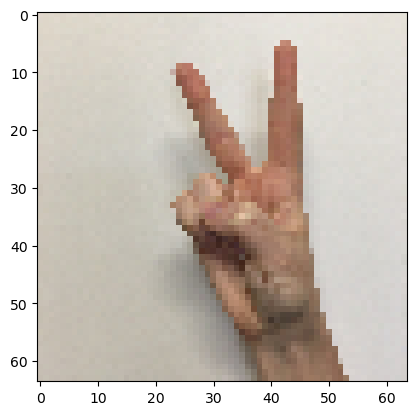

In [26]:
img_path = 'images/my_image.jpg'
img = image.load_img(img_path, target_size=(64, 64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x/255.0
print('Input image shape:', x.shape)
imshow(img)
prediction = pre_trained_model.predict(x)
print("Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ", prediction)
print("Class:", np.argmax(prediction))


You can also print a summary of your model by running the following code.

In [25]:
pre_trained_model.summary()

NameError: name 'pre_trained_model' is not defined

<a name='6'></a>  
## 6 - Bibliography

This notebook presents the ResNet algorithm from He et al. (2015). The implementation here also took significant inspiration and follows the structure given in the GitHub repository of Francois Chollet: 

- Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun - [Deep Residual Learning for Image Recognition (2015)](https://arxiv.org/abs/1512.03385)
- Francois Chollet's GitHub repository: https://github.com/fchollet/deep-learning-models/blob/master/resnet50.py
